In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch import distributions
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML

In [8]:
device = torch.device( 'cpu') #'cuda' if torch.cuda.is_available() else 

# Normalising flows: comparison to CNF
In this notebook we compare the performance of CNF to a normalising flow with a similar architecture. As with the CNF example, we will learn a two-modal distribution with two concentric circles, and a uniform distribution of a triangle.
## Hyperparameters

In [4]:
args = {
    'niters': 5000,
    'lr': 1e-4,
    'num_samples': 500,
}

## The Model

We will use a normalising flow with the following architecture, so it is similar to that of the CNF:
- 10 layers
- Hypernet with 2 hidden layers to generate the parameters of the affine transformation
- Affine transformation

The hypernet is conditioned on the context, which is the same as the CNF.

In [32]:
class NF(nn.Module):
    """RealNVP model with spatial checkerboard mask."""
    
    def __init__(self, in_out_dim, hidden_dim, num_layers, num_transformations):
        super(NF, self).__init__()
        
        self.prior = distributions.MultivariateNormal(torch.zeros(in_out_dim), torch.eye(in_out_dim))
        self.masks = nn.Parameter(
            torch.from_numpy(np.array([[0, 1], [1, 0]] * (num_transformations // 2)).astype(np.float32)), requires_grad=False)
        self.t = torch.nn.ModuleList([nn.Sequential( # s network
            nn.Linear(in_out_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, in_out_dim),
            nn.Tanh(),
        ) for _ in range(len(self.masks))])
        self.s = torch.nn.ModuleList([nn.Sequential( # t network
            nn.Linear(in_out_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, in_out_dim),
        ) for _ in range(len(self.masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.masks[i]
            s = self.s[i](x_)*(1 - self.masks[i])
            t = self.t[i](x_)*(1 - self.masks[i])
            x = x_ + (1 - self.masks[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x

        for i in reversed(range(len(self.t))):
            z_ = self.masks[i] * z
            s = self.s[i](z_) * (1-self.masks[i])
            t = self.t[i](z_) * (1-self.masks[i])
            z = (1 - self.masks[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)

        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    
    def sample_progressive(self, x, i):
        x_ = x*self.masks[i]
        s = self.s[i](x_)*(1 - self.masks[i])
        t = self.t[i](x_)*(1 - self.masks[i])
        x = x_ + (1 - self.masks[i]) * (x * torch.exp(s) + t)
        return x

## Traingular distribution

In [18]:
def point_on_triangle(pt1, pt2, pt3):
    """
    Random point on the triangle with vertices pt1, pt2 and pt3.
    """
    x, y = random.random(), random.random()
    q = abs(x - y)
    s, t, u = q, 0.5 * (x + y - q), 1 - 0.5 * (q + x + y)
    return (
        s * pt1[0] + t * pt2[0] + u * pt3[0],
        s * pt1[1] + t * pt2[1] + u * pt3[1],
    )


def get_batch(num_samples):
    """
    Generate random points uniformly distributed inside a custom triangle.
    """
    pt1 = [-0.2, 0.0]
    pt2 = [0.6, 0.0]
    pt3 = [0.0, 0.7]

    # Generate random points inside the triangle
    points = [point_on_triangle(pt1, pt2, pt3) for _ in range(num_samples)]

    x = torch.tensor(points).type(torch.float32)
    return x

## Define the model

In [19]:
model_triangle = NF(in_out_dim=2, hidden_dim=256, num_layers=1, num_transformations=6).to(device)
optimizer_triangle = optim.Adam([p for p in model_triangle.parameters() if p.requires_grad == True], lr=args['lr'])
print("The model has {} trainable parameters".format(sum(p.numel() for p in model_triangle.parameters() if p.requires_grad)))

The model has 804888 trainable parameters


## Train the model

In [20]:
def train_nf(model, optimizer):
    for i in range(1,args['niters']+1):
        sample = get_batch(args['num_samples']).to(device)
        loss = -model.log_prob(sample).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Iter {i}, Loss: {loss.item()}')
            
train_nf(model_triangle, optimizer_triangle)

Iter 100, Loss: -1.1147778034210205
Iter 200, Loss: -1.1444945335388184
Iter 300, Loss: -1.1983345746994019
Iter 400, Loss: -1.2022931575775146
Iter 500, Loss: -1.1850473880767822
Iter 600, Loss: -1.2344552278518677
Iter 700, Loss: -1.210594892501831
Iter 800, Loss: -1.2275450229644775
Iter 900, Loss: -1.2324777841567993
Iter 1000, Loss: -1.1281862258911133
Iter 1100, Loss: -1.2215667963027954
Iter 1200, Loss: -1.22849702835083
Iter 1300, Loss: -1.2288917303085327
Iter 1400, Loss: -1.2394450902938843
Iter 1500, Loss: -1.2283189296722412
Iter 1600, Loss: -1.241601586341858
Iter 1700, Loss: -1.195736050605774
Iter 1800, Loss: -1.2337664365768433
Iter 1900, Loss: -1.2440791130065918
Iter 2000, Loss: -1.201674461364746
Iter 2100, Loss: -1.25162672996521
Iter 2200, Loss: -1.2448558807373047
Iter 2300, Loss: -1.2387827634811401
Iter 2400, Loss: -1.2242354154586792
Iter 2500, Loss: -1.2203017473220825
Iter 2600, Loss: -1.1840050220489502
Iter 2700, Loss: -1.2127022743225098
Iter 2800, Loss: -

## Plot the results

In [22]:
def viz_nf(model, results_dir,  viz_samples=30000):
    target = get_batch(viz_samples).cpu()
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
    with torch.no_grad():
        # Generate evolution of samples
        current_sample = model.prior.sample((viz_samples,)).cpu()
        
        # Create plot for each transformation
        for i in range(len(model.masks)):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
            plt.suptitle(f'Transformation {i+1}')
            plt.tight_layout()
            
            current_sample = model.cpu().sample_progressive(current_sample, i).cpu()
            
            axes[0].set_title('Target')
            axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
            
            axes[1].set_title('Model')
            axes[1].hist2d(*current_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
            
            file_number = str(i + 1).zfill(len(str(len(model.masks))))
            plt.savefig(os.path.join(results_dir, f'nf-viz-{file_number}.png'))
            plt.close()
            
        # Display GIF
        gif_imgs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if f.endswith('.png')]
        img, *imgs = [Image.open(img) for img in gif_imgs]
        gif_path = os.path.join(results_dir, "nf-viz.gif")
        img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, duration=250, loop=0)
        display(HTML(f'<img src="{gif_path}" width="{1000}">'))
        img.close()
        for im in imgs:
            im.close()

viz_nf(model_triangle, 'triangle_results')


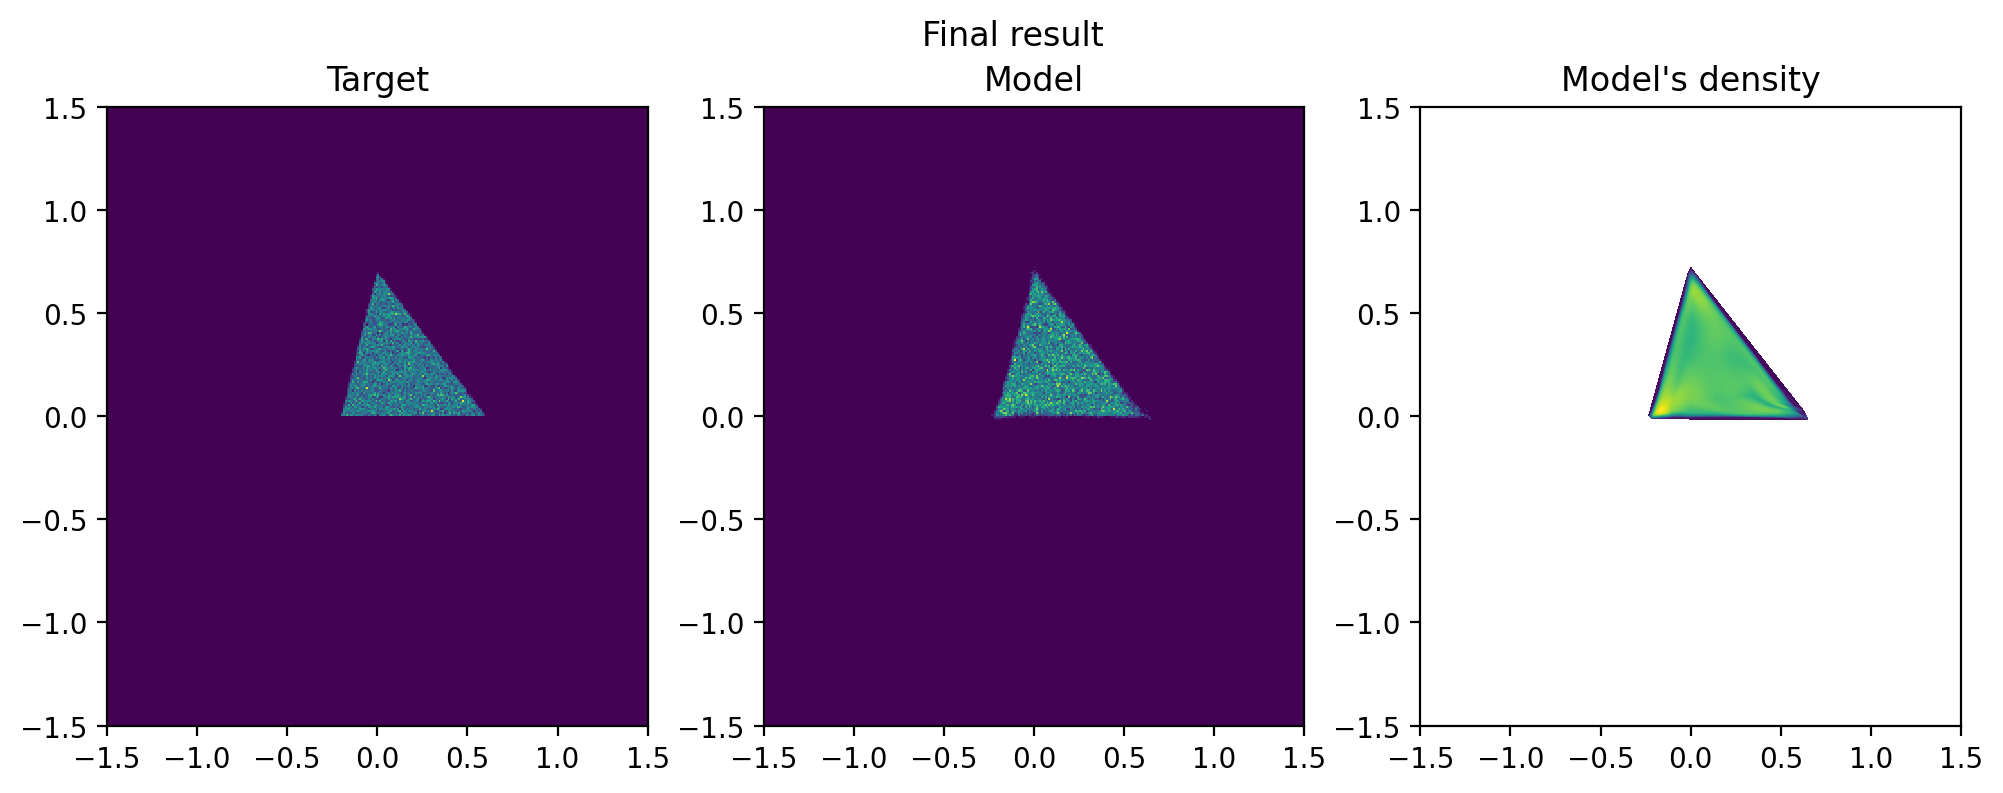

In [27]:
# Plot final result
def nf_final(model, viz_samples = 30000):
    model = model.to(device)
    target = get_batch(viz_samples).to(device)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=200)
    plt.suptitle(f'Final result')
    plt.tight_layout()
    
    trans_sample = model.sample(viz_samples).view(30000,2).to(device)
    logp = model.log_prob(trans_sample)
    
    axes[0].set_title('Target')
    axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[1].set_title('Model')
    axes[1].hist2d(*trans_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[2].set_title("Model's density")
    # Set x-axis and y-axis limits
    axes[2].set_xlim(-1.5, 1.5)
    axes[2].set_ylim(-1.5, 1.5)
    axes[2].tricontourf(*trans_sample.detach().cpu().numpy().T, np.exp(logp.detach().cpu().numpy()), 200)
    
    plt.show()
    del model
    
nf_final(model_triangle)

### Concentric circles

In [33]:
from sklearn.datasets import make_circles
def get_batch(num_samples):
    """
    Generate random points in a two concentric circles distribution.
    """
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = torch.tensor(points).type(torch.float32)
    return x

#### Define the model

In [34]:
model_circles = NF(in_out_dim=2, hidden_dim=256, num_layers=1, num_transformations=6).to(device)
optimizer_circles = optim.Adam([p for p in model_circles.parameters() if p.requires_grad == True], lr=args['lr'])
print("The model has {} trainable parameters".format(sum(p.numel() for p in model_circles.parameters() if p.requires_grad)))

The model has 804888 trainable parameters


#### Train the model

In [35]:
train_nf(model_circles, optimizer_circles)

Iter 100, Loss: 1.4689958095550537
Iter 200, Loss: 1.4918420314788818
Iter 300, Loss: 1.4772930145263672
Iter 400, Loss: 1.5036840438842773
Iter 500, Loss: 1.4446825981140137
Iter 600, Loss: 1.5121042728424072
Iter 700, Loss: 1.4310190677642822
Iter 800, Loss: 1.841945767402649
Iter 900, Loss: 1.5637034177780151
Iter 1000, Loss: 1.5501213073730469
Iter 1100, Loss: 1.4937574863433838
Iter 1200, Loss: 1.4887418746948242
Iter 1300, Loss: 1.4504029750823975
Iter 1400, Loss: 1.7957862615585327
Iter 1500, Loss: 1.4395208358764648
Iter 1600, Loss: 1.5043500661849976
Iter 1700, Loss: 1.4247300624847412
Iter 1800, Loss: 1.4294697046279907
Iter 1900, Loss: 1.3825322389602661
Iter 2000, Loss: 1.3771240711212158
Iter 2100, Loss: 1.3547919988632202
Iter 2200, Loss: 1.4281768798828125
Iter 2300, Loss: 1.3683829307556152
Iter 2400, Loss: 1.3745187520980835
Iter 2500, Loss: 1.3840978145599365
Iter 2600, Loss: 1.3886756896972656
Iter 2700, Loss: 1.3518363237380981
Iter 2800, Loss: 1.3069790601730347
It

#### Plot the results

In [36]:
viz_nf(model_circles, 'circles_results')

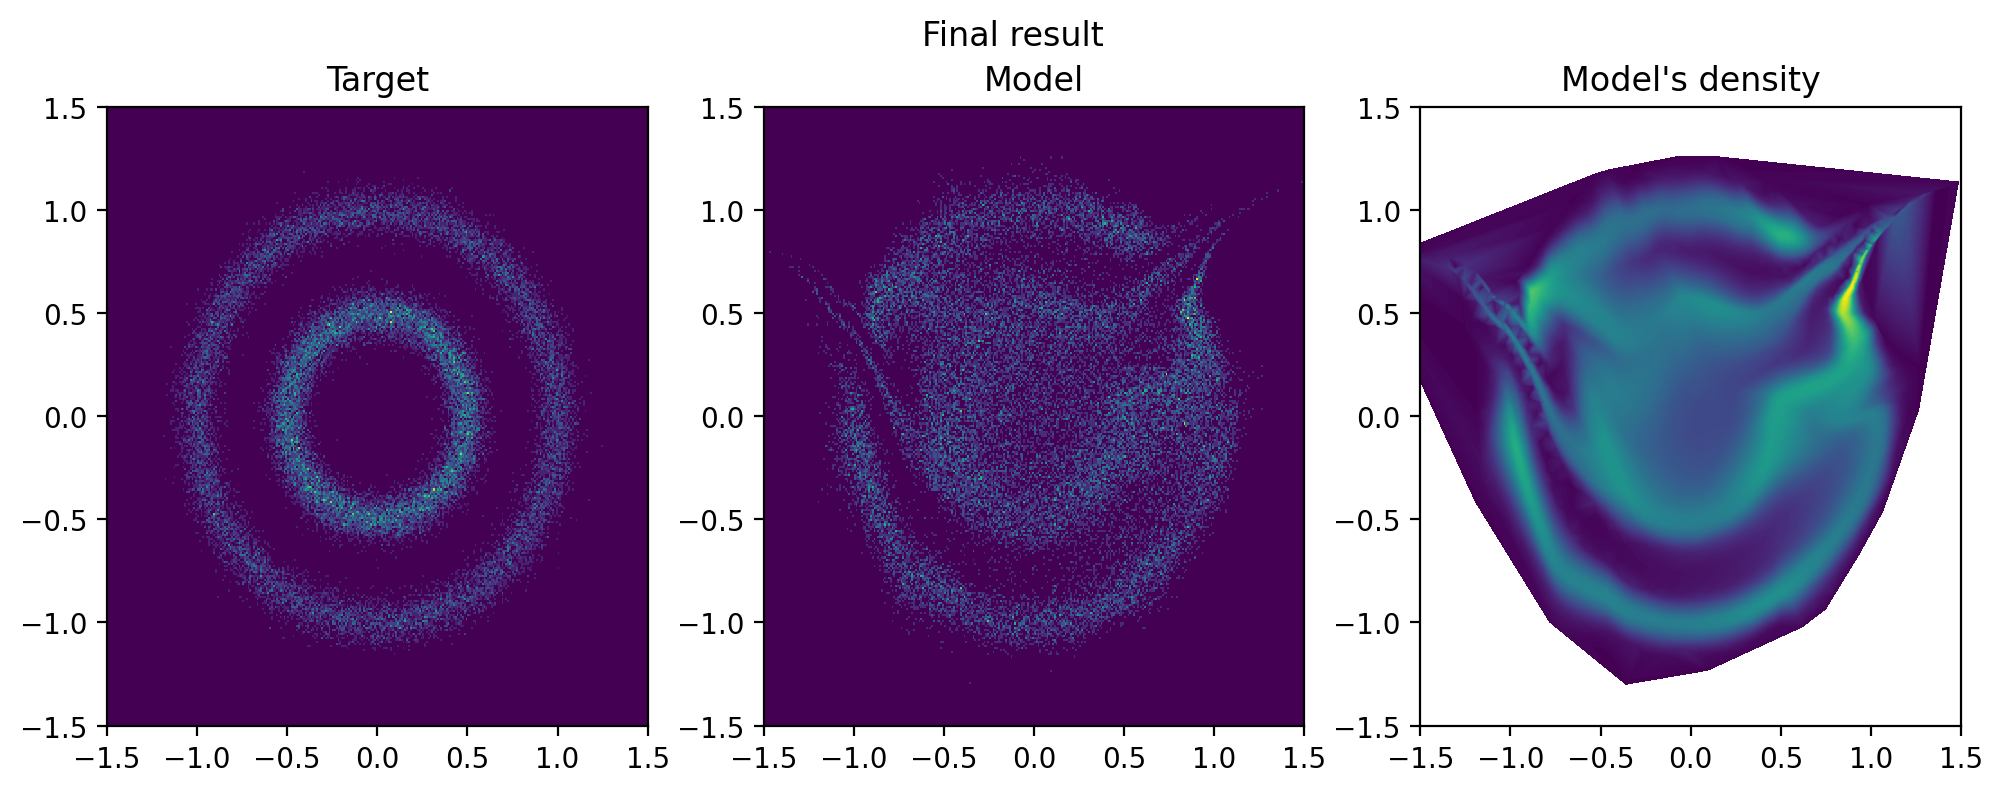

In [37]:
nf_final(model_circles)

## Comparison
### 